In [29]:
import pandas as pd
import numpy as np
data = pd.read_csv("data/Chest_xray_Corona_Metadata.csv")
data

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [12]:
# Printing unique labels
unique_labels = []
for i in  data['Label']:
    if i not in unique_labels:
        unique_labels.append(i)
        
print(unique_labels)

['Normal', 'Pnemonia']


In [13]:
import os
import pandas as pd
import time
import shutil

PATH_TRAIN = "data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
TOTAL_IMGS = len(os.listdir(PATH_TRAIN))
normal = 0
infected = 0



img = data["X_ray_image_name"]
label = data["Label"]
image_type = data["Dataset_type"]
all_dir = os.listdir(PATH_TRAIN)

os.mkdir("test")
os.mkdir('test/INFECTED')
os.mkdir("test/NORMAL")

wrong_info = 0  # Checking if the provided list maps the images correctly

# Moving the train images to designated folders

for i in range(len(image_type)):
    if image_type[i] == "TRAIN":
        if img[i] in all_dir: # Make sure that all images in Chest_xray_Corona_Metadata.csv is mapped
            if label[i] == "Normal":
                infected = infected + 1
                shutil.copy(
                    PATH_TRAIN + "/" + img[i], "test/NORMAL/" + img[i]
                )
                normal = normal + 1

            else:

                shutil.copy(
                    PATH_TRAIN + "/" + img[i], "train/INFECTED/" + img[i]
                )
                infected = infected + 1

        else:
            wrong_info = wrong_info + 1

print(
    "X-ray of Normal patients (TRAIN DATASET): " + str(normal),
    "X-ray of Infected patients (TRAIN DATASET): " + str(infected),
    end = "\n"
)

FileExistsError: [Errno 17] File exists: 'train'

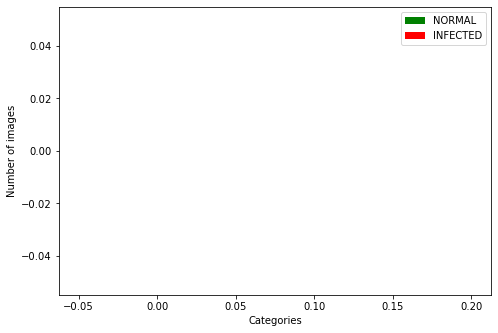

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
categories = ["NORMAL", "INFECTED"]
number_of_imgs = [normal, infected]
ax.bar(0, number_of_imgs[0], color="g", width=0.1)
ax.bar(0.15, number_of_imgs[1], color="r", width=0.1)
ax.legend(labels=categories)
ax.set_ylabel("Number of images")
ax.set_xlabel("Categories")
plt.show()

In [15]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        n = 0
        for f in files:
            n = n+1
            if n>5:
                print('{}{}'.format(subindent, f),end = "  ...... \n")
                break
            print('{}{}'.format(subindent, f))


list_files("/content/Coronahack-Chest-XRay-Dataset")

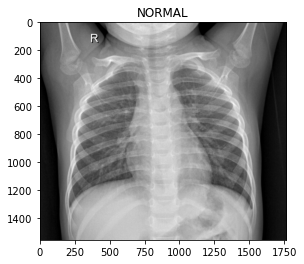

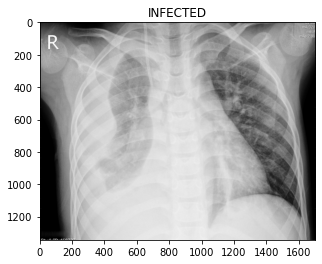

In [16]:
import cv2

normal_sample = cv2.imread("train/NORMAL/"+os.listdir("train/NORMAL")[3])
infected_sample = cv2.imread("train/INFECTED/"+os.listdir("train/INFECTED")[2])

plt.imshow(normal_sample)
plt.title("NORMAL")
plt.show()

plt.imshow(infected_sample)
plt.title("INFECTED")
plt.show()

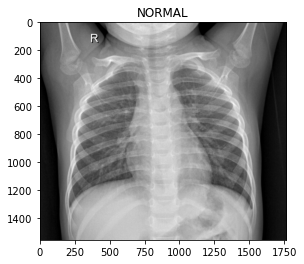

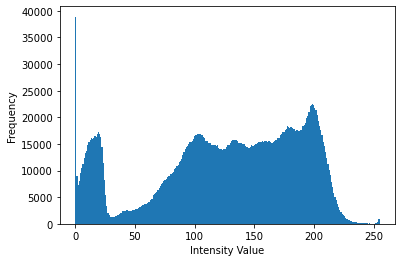

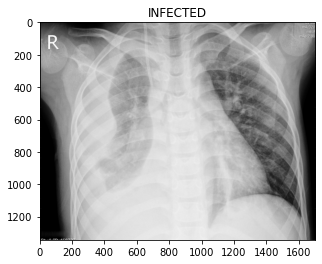

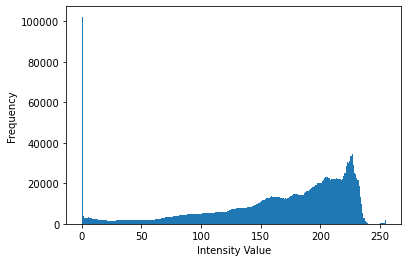

In [17]:
from skimage import io
import matplotlib.pyplot as plt

plt.imshow(normal_sample)
plt.title("NORMAL")
plt.show()

image = io.imread("train/NORMAL/"+os.listdir("train/NORMAL")[3])
ax = plt.hist(image.ravel(), bins = 256)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

plt.imshow(infected_sample)
plt.title("INFECTED")
plt.show()

image = io.imread("train/INFECTED/"+os.listdir("train/INFECTED")[2])
ax = plt.hist(image.ravel(), bins = 256)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import time
import torchvision
from PIL import ImageFile
import matplotlib.pyplot as plt
import cv2

In [63]:
# Load ResNet-50 and DenseNet-121 model seperately here
import torchvision.models as models
resnet = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ilkay/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [54]:
ImageFile.LOAD_TRUNCATED_IMAGES = True # To prevent error during loading broken images

PATH_TRAIN = "train"
PATH_TEST  = "test"
EPOCHS = 10
BATCH_SIZE = 64
TOTAL_SIZE = len(os.listdir(PATH_TRAIN + "/NORMAL")) + len(
    os.listdir(PATH_TRAIN + "/INFECTED")
)
TOTAL_TEST_SIZE = len(os.listdir(PATH_TEST + "/NORMAL")) + len(
    os.listdir(PATH_TEST + "/INFECTED")
)
STEPS_PER_EPOCH = TOTAL_SIZE // BATCH_SIZE
STEPS_PER_TEST_EPOCH = TOTAL_TEST_SIZE // BATCH_SIZE
IMAGE_H, IMAGE_W = 224, 224

In [55]:
transform = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((IMAGE_H, IMAGE_W)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)  # Normalizing data

# Intitalizing the train data loader and applying the transformations

train_dataset = torchvision.datasets.ImageFolder(root=PATH_TRAIN, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=1, shuffle=True
)

# Intitalizing the test data loader

test_dataset = torchvision.datasets.ImageFolder(
    root=PATH_TEST, transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=1, shuffle=True
)

In [59]:
###  Here are some training parameters which you can tweak
# Device configuration
#device = torch.device('cuda:0')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 64
learning_rate = 1e-3
regularization_rate = 0
n_epochs = 1
use_gpu = True
test_every = 3
###
model = densenet.to(device)

# You may want to tweak them too and you can use different parameter settings for different models. 
# These are just examples
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criteria = nn.CrossEntropyLoss()

In [60]:
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
# Use your own model
learning_rate = 1e-4
model.train()
if use_gpu:
    model.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
losses_epoch_train = []
accuracy_iter_train = []
accuracy_epoch_train = []

losses_iter_val = []
losses_epoch_val = []
accuracy_iter_val = []
accuracy_epoch_val = []
n_epochs = 30
total_step = len(train_loader)
# Write the training loop
# Write the training loop
for epoch in range(n_epochs):
    for ix, data in enumerate(train_loader):
        model.zero_grad()
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()

        images = img.to(device)
        labels = label.to(device)

        # Forward pass through the model
        outputs = model(images)
        # Calculate your loss
        loss = criteria(outputs, labels)
        losses_iter_train.append(loss.item()) 
        # Backward and optimize
        # If you don't accumulate the gradients then you should
        # zero grads before calculate them
        optimizer.zero_grad()
        loss.backward()
        # Make a step with your optimizer
        optimizer.step()
        
        # To monitor the training process we print or log some useful values 
        if (ix+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epochs, ix+1, total_step, loss.item()))
    losses_epoch_train.append(np.mean(losses_iter_train))
    # At each epoch we perform validation to see whether our model overfit the data or not
    # We shouldn't learn anything from validation data so it looks like we are testing
    with torch.no_grad():
        correct = 0
        total = 0
        for iy, data_ in enumerate(test_loader):
            img_, label_ = data_

            images_ = img_.to(device)
            labels_ = label_.to(device)

            outputs_ = model(images_)
            _, predicted = torch.max(outputs_.data, 1)
            val_loss = criteria(outputs_, labels_)
            losses_iter_val.append( val_loss.item() )

            total += labels_.size(0)
            correct += (predicted == labels_).sum().item()
        losses_epoch_val.append(np.mean(losses_iter_val))
        print(f"Validation Accuracy of the model on the {total} validation images: {100 * correct / total} ")

Validation Accuracy of the model on the 624 validation images: 82.21153846153847 
Validation Accuracy of the model on the 624 validation images: 79.48717948717949 
Validation Accuracy of the model on the 624 validation images: 80.12820512820512 
Validation Accuracy of the model on the 624 validation images: 81.73076923076923 
Validation Accuracy of the model on the 624 validation images: 81.08974358974359 
Validation Accuracy of the model on the 624 validation images: 82.05128205128206 
Validation Accuracy of the model on the 624 validation images: 81.73076923076923 
Validation Accuracy of the model on the 624 validation images: 77.40384615384616 
Validation Accuracy of the model on the 624 validation images: 76.28205128205128 
Validation Accuracy of the model on the 624 validation images: 82.53205128205128 
Validation Accuracy of the model on the 624 validation images: 84.2948717948718 
Validation Accuracy of the model on the 624 validation images: 82.53205128205128 
Validation Accura

KeyboardInterrupt: 

In [62]:
pip uninstall ipywid

Note: you may need to restart the kernel to use updated packages.
